In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
#np.set_printoptions(threshold=sys.maxsize)
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

from pandas import read_csv
from scipy import signal

In [156]:
data = pd.read_csv('051622 Sample 1.txt', delimiter='\t', header=None)
pv = data[1].to_numpy()
T_s = data[0][1] - data[0][0]
timestamp = np.arange(start = 0, stop = len(pv)*T_s, step = T_s)
timestamp = timestamp[np.logical_not(np.isnan(timestamp))]
timestamp -= timestamp[0]

f_s = 1/T_s
increment_s = 0.01
timestamp_ds = np.arange(0, timestamp[-1], increment_s)

(0.0, 0.016)

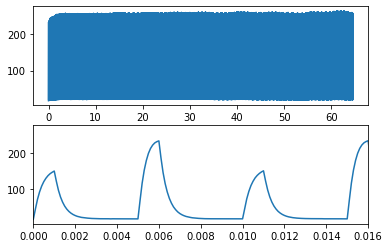

In [157]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(timestamp ,pv)
ax2.plot(timestamp ,pv)
ax2.set_xlim(0, 160*T_s)

In [158]:
#decompose series
from statsmodels.tsa.seasonal import seasonal_decompose

def det_sea(sig, window_length_sa=20, period=100):
    sig_dec = seasonal_decompose(sig, model='additive', period=period)
    sig_adj = sig - sig_dec.seasonal - np.nan_to_num(sig_dec.trend)
    sig_den = np.convolve(sig_adj, np.ones(window_length_sa)/window_length_sa, mode='same')
    return sig_den

# red
red_offset_s = 0.001
red = pv[int(red_offset_s*f_s):-1:int(increment_s*f_s)]
red_den = det_sea(red)

# nir
nir_offset_s = 0.006
nir = pv[int(nir_offset_s*f_s):-1:int(increment_s*f_s)]
decompose_series = seasonal_decompose(nir, model='additive',period=100)
nir_den = det_sea(nir)


In [159]:
peaks_red, _ = find_peaks(-red_den, distance=100)
peaks_nir, _ = find_peaks(-nir_den, distance=100)
adj_peaks_red = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_red, peaks_red+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)
adj_peaks_nir = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_nir, peaks_nir+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)
max_length_red = (adj_peaks_red[:,1]-adj_peaks_red[:,0]).max() # max length of denoised slices
n_slices_red = len(adj_peaks_red) # number of slices
max_length_nir = (adj_peaks_nir[:,1]-adj_peaks_nir[:,0]).max() # max length of denoised slices
n_slices_nir = len(adj_peaks_nir) # number of slices



In [160]:
#initialize
slices_red = []
slices_nir = []
for i in range(n_slices_red):
    length_now_red = (adj_peaks_red[i,1]-adj_peaks_red[i,0])
    if length_now_red < max_length_red:
        slices_red.append(np.pad(red_den[adj_peaks_red[i,0]:adj_peaks_red[i,1]], (0, max_length_red-length_now_red), 'constant', constant_values = 0))

for i in range(n_slices_nir):
    length_now_nir = (adj_peaks_red[i,1]-adj_peaks_red[i,0])
    if length_now_nir < max_length_nir:
        slices_nir.append(np.pad(nir_den[adj_peaks_nir[i,0]:adj_peaks_nir[i,1]], (0, max_length_nir-length_now_nir), 'constant', constant_values = 0))

slices_red = np.array(slices_red)
slices_nir = np.array(slices_nir)



/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_32771/2068184398.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  slices_nir = np.array(slices_nir)


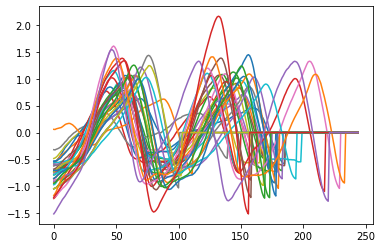

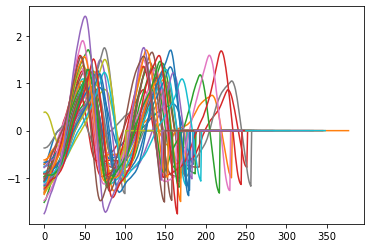

In [161]:
#plot for slices_red
for i in range(1, n_slices_red-2):
    plt.plot(slices_red[i])
plt.show()

#plot for slices_nir
for i in range(1, n_slices_nir-1):
    plt.plot(slices_nir[i])
plt.show()
